In [1]:
%matplotlib inline
from setuptools import setup
import warnings
import cv2
import nbformat as nbf
import nbconvert as nbc
import papermill as pm
import decimal
import imageio  # for reading image files
from html.parser import HTMLParser
import matplotlib
import matplotlib.cm as cm
from matplotlib.path import Path
from matplotlib.image import imread
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter, MultipleLocator, FixedLocator, FixedFormatter, LogLocator, LogFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import numpy.distutils.ccompiler
import glob
import math
import random as rnd
import scipy
from scipy import interpolate, integrate
from scipy.interpolate import griddata, interp1d, UnivariateSpline
import scipy.fftpack as fftengine
import pylab
import seaborn as sns
import skimage.filters
import skimage.color
import skimage.io
from skimage import segmentation, data, filters, measure, morphology
from skimage.measure import find_contours, approximate_polygon, subdivide_polygon
from shapely import Point, Polygon
import camb
from camb import model, initialpower
from astropy.convolution import convolve, convolve_fft
from astropy.io import fits
import astropy.units as u
from astropy.units import deg
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import LambdaCDM as lcdm
import pyccl as ccl
from FyeldGenerator import generate_field
from lenstools import dataExtern, ConvergenceMap, ShearMap, GaussianNoiseGenerator
import shutil
import re
import os
import sys
import magic
sys.modules["mpi4py"] = None
plt.rcParams['pgf.texsystem'] = 'pdflatex'
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "text.usetex": True,
    "pgf.rcfonts": False,
})

# Add the local 'pyTwinPeaks' module to the Python path (if not using pip install yet)
sys.path.append(os.path.join(os.getcwd(), "pyTwinPeaks"))

# Import your module
from pyTwinPeaks import Finder_functions as mystery

# Path to the current notebook (optional)
notebook_path = os.path.join("notebooks", "example_run.ipynb")


/tmp/ipykernel_202138/420459180.py:23: DeprecationWarning: 

  `numpy.distutils` is deprecated since NumPy 1.23.0, as a result
  of the deprecation of `distutils` itself. It will be removed for
  Python >= 3.12. For older Python versions it will remain present.
  It is recommended to use `setuptools < 60.0` for those Python versions.
  For more details, see:
    https://numpy.org/devdocs/reference/distutils_status_migration.html 


  import numpy.distutils.ccompiler


In [2]:
# Define the cosmology you want to use
cosmoin = ["LCDM", "fR4", "fR5", "fR6", "LCDM_0.15"]
c_run = 0 #In sincro with the value in All_maps.ipynb

# Define the light-cone you want to use
l_c = "01"

# Define the ID run you want to use
i_fil = "2"

# Define base paths relative to the repository structure
pre_path = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Input folder where the kappa .fits maps are stored (e.g., data/LCDM/00/)
folderin = os.path.join(pre_path, "data", cosmoin[c_run], l_c)
filin = os.path.join(folderin, f"{i_fil}_kappaBApp.fits")

# Output folder for saving results (e.g., outputs/LCDM/00/)
#output_dir = os.path.join(pre_path, "outputs", cosmoin[c_run] + "/")
#os.makedirs(output_dir, exist_ok=True)
folderout = os.path.join(pre_path, "outputs", cosmoin[c_run], l_c + "/")
os.makedirs(folderout, exist_ok=True)

# Define object to search in the projected convergence field: 'peaks' or 'valleys'
search = ['peaks', 'valleys']
p_obj = search[1] #Select underdense line of sight

# Define the smoothing filter widths (in arcmin) 
smooth_filters = [1, 2.5, 5]
smooth_filter_set = smooth_filters[1] # Select 2.5 as the smoothing scale

# Create output folder path for current run (e.g., outputs/LCDM/00/valleys_i_fil_k/)
path = os.path.join(folderout, f"{p_obj}_{i_fil}k/")

# Set the threshold value to start the watershed absolute minima selection on the SNR map
threshold_value = 4

# Set the threshold value to stop the watershed absolute minima selection on the SNR map
stop_th = 3 

# Set the threshold vlaue to define the radius of the object on SNR map (e.g., the circular base of tunnel voids)
SNR_threshold = 2.5 #It is recommended to stay around this value, as it has been tested to be the best balance between signal strength and sample robustness 

# Define the source galaxy number density (per arcmin²) for simulating noise levels
n_gal = [10, 30, 50]
n_gal_set = n_gal[1] #Euclid-like set-up

# Variance of the intrinsic ellipticity distribution of the source galaxies (Lin & Kilbinger 2015)
ell_err = 0.3 #Euclid-like set-up

color = ["dodgerblue", "green", "red"]


fov [deg] =  5.0
number of pixels =  2048
zs =  1.00094343049
pixel size [arcmin] =  0.146484375
fov [arcmin] 300.0
sigma_noise in arcmin (final N)= 0.006180387232371033
sigma GSN per pixel = 0.26439566310109297
sigma of the final smooth filter in pixel = 12.067955732250411

 number of connected regions SNR>= 0 :  90
 number of connected regions SNR>= 0.5 :  141
 number of connected regions SNR>= 1 :  218
 number of connected regions SNR>= 1.5 :  287
 number of connected regions SNR>= 2 :  332
 number of connected regions SNR>= 2.5 :  340
 number of connected regions SNR>= 3 :  266
 number of connected regions SNR>= 3.5 :  186
 number of connected regions SNR>= 4 :  111


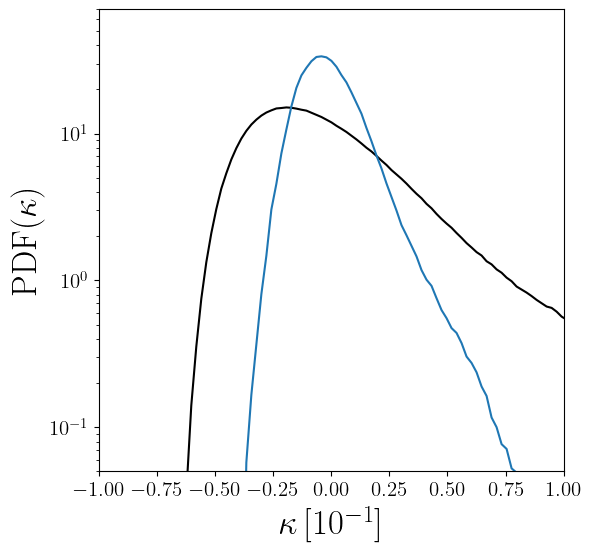

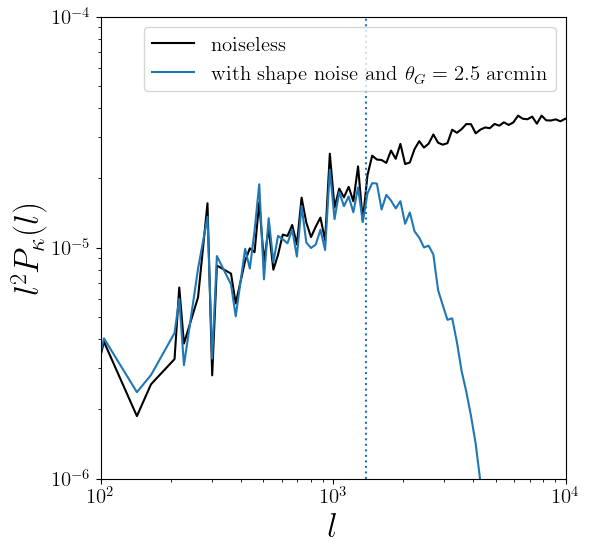

In [3]:
mystery.cleaning_ambient(folderout, search, i_fil)
SNR_final, kappa_final, kappa_original, fov_arcmin, npixel = mystery.connected_regions(filin,
                                                                                       folderout,
                                                                                       ell_err,
                                                                                       smooth_filter_set,
                                                                                       n_gal_set,
                                                                                       path,
                                                                                       p_obj,
                                                                                       i_fil,
                                                                                       1234)
                                                                                        #int(time.time() * 1000)

mystery.map_PDF_and_Pl(folderout,
                       SNR_final,
                       kappa_original,
                       kappa_final,
                       fov_arcmin,
                       smooth_filter_set,
                       512,
                       256)

Voids found: 86
Voids after cleaning: 85


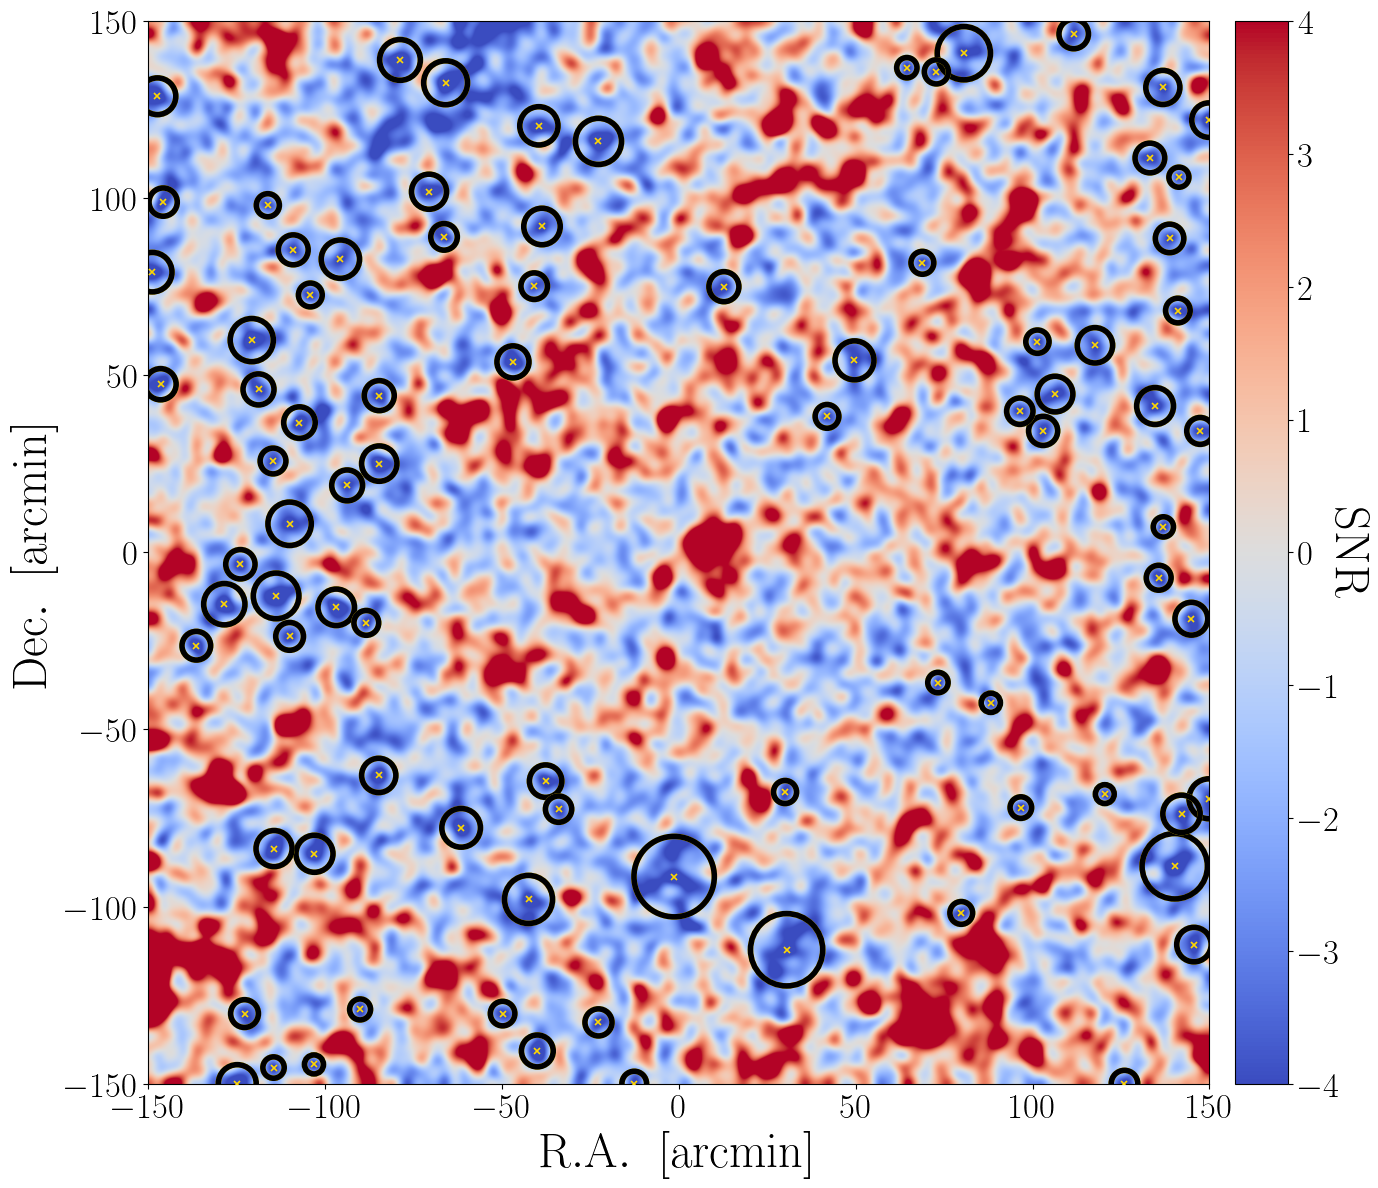

In [4]:
exist, x_v_arc, y_v_arc, snr_map = mystery.void_minima(path, 
                                                       p_obj,
                                                       smooth_filter_set,
                                                       SNR_final,
                                                       fov_arcmin,
                                                       threshold_value, 
                                                       stop_th)
mystery.void_radii(exist, 
                   folderout, 
                   snr_map, 
                   fov_arcmin, 
                   threshold_value, 
                   x_v_arc, y_v_arc, 
                   npixel, 
                   SNR_threshold)

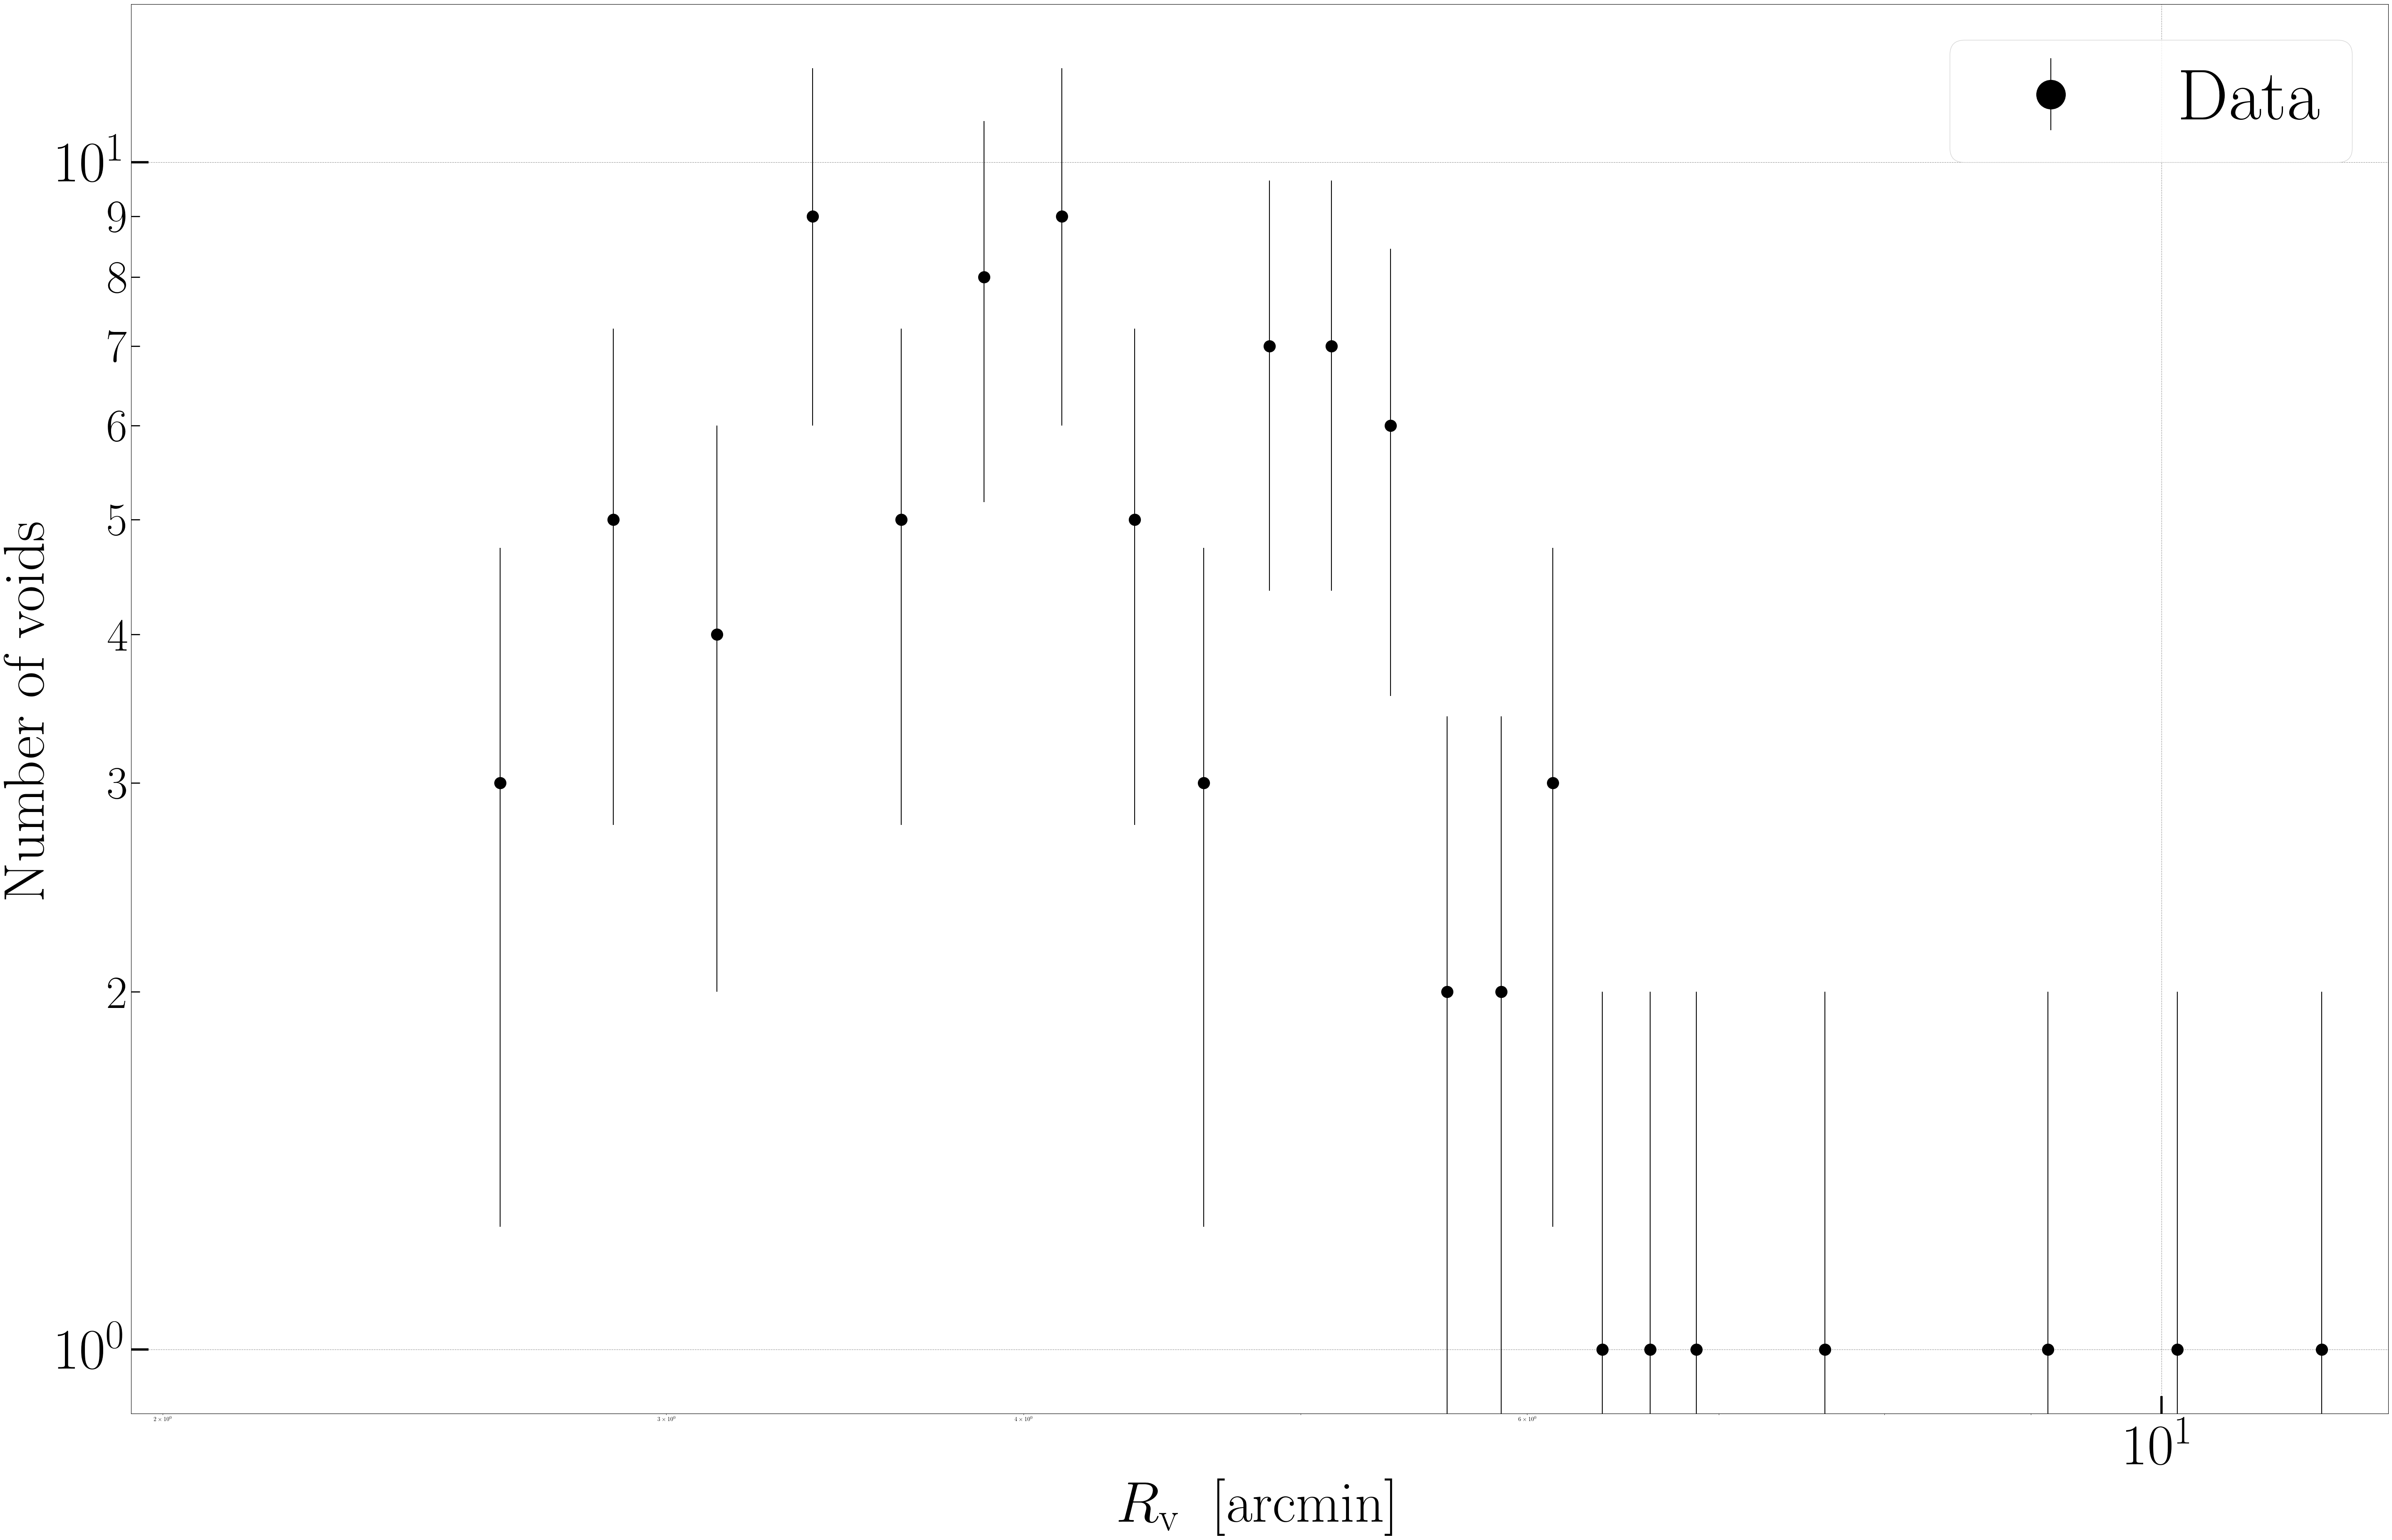

In [5]:
if exist:
    max_r, min_r, bins, vsf, err_vsf = mystery.map_vsf(folderout, 40, True, False, True)
    equibins, folder_names = mystery.create_stacks_folders(folderout, min_r, max_r, i_fil, smooth_filter_set, 3, False)
else:
    print("No voids found")

void 1 : (120.41016, -68.26172) radius:  2.66047 arcmin
void 2 : (-103.125, -144.58008) radius:  2.68328 arcmin
void 3 : (88.18359, -42.48047) radius:  2.71597 arcmin
void 4 : (141.35742, 105.9082) radius:  2.83123 arcmin
void 5 : (136.96289, 7.17773) radius:  2.8583 arcmin
void 6 : (64.45312, 136.81641) radius:  2.86978 arcmin
void 7 : (73.24219, -36.76758) radius:  2.88054 arcmin
void 8 : (-90.08789, -129.05273) radius:  2.95961 arcmin
void 9 : (-114.55078, -145.45898) radius:  3.01686 arcmin
void 10 : (96.67969, -72.07031) radius:  3.04477 arcmin
void 11 : (79.83398, -101.80664) radius:  3.21498 arcmin
void 12 : (68.84766, 81.73828) radius:  3.23186 arcmin
void 13 : (-116.16211, 97.99805) radius:  3.2564 arcmin
void 14 : (30.0293, -67.67578) radius:  3.25859 arcmin
void 15 : (101.36719, 59.47266) radius:  3.29146 arcmin
void 16 : (41.89453, 38.37891) radius:  3.35405 arcmin
void 17 : (-104.15039, 72.65625) radius:  3.3608 arcmin
void 18 : (72.80273, 135.64453) radius:  3.40232 arcmi

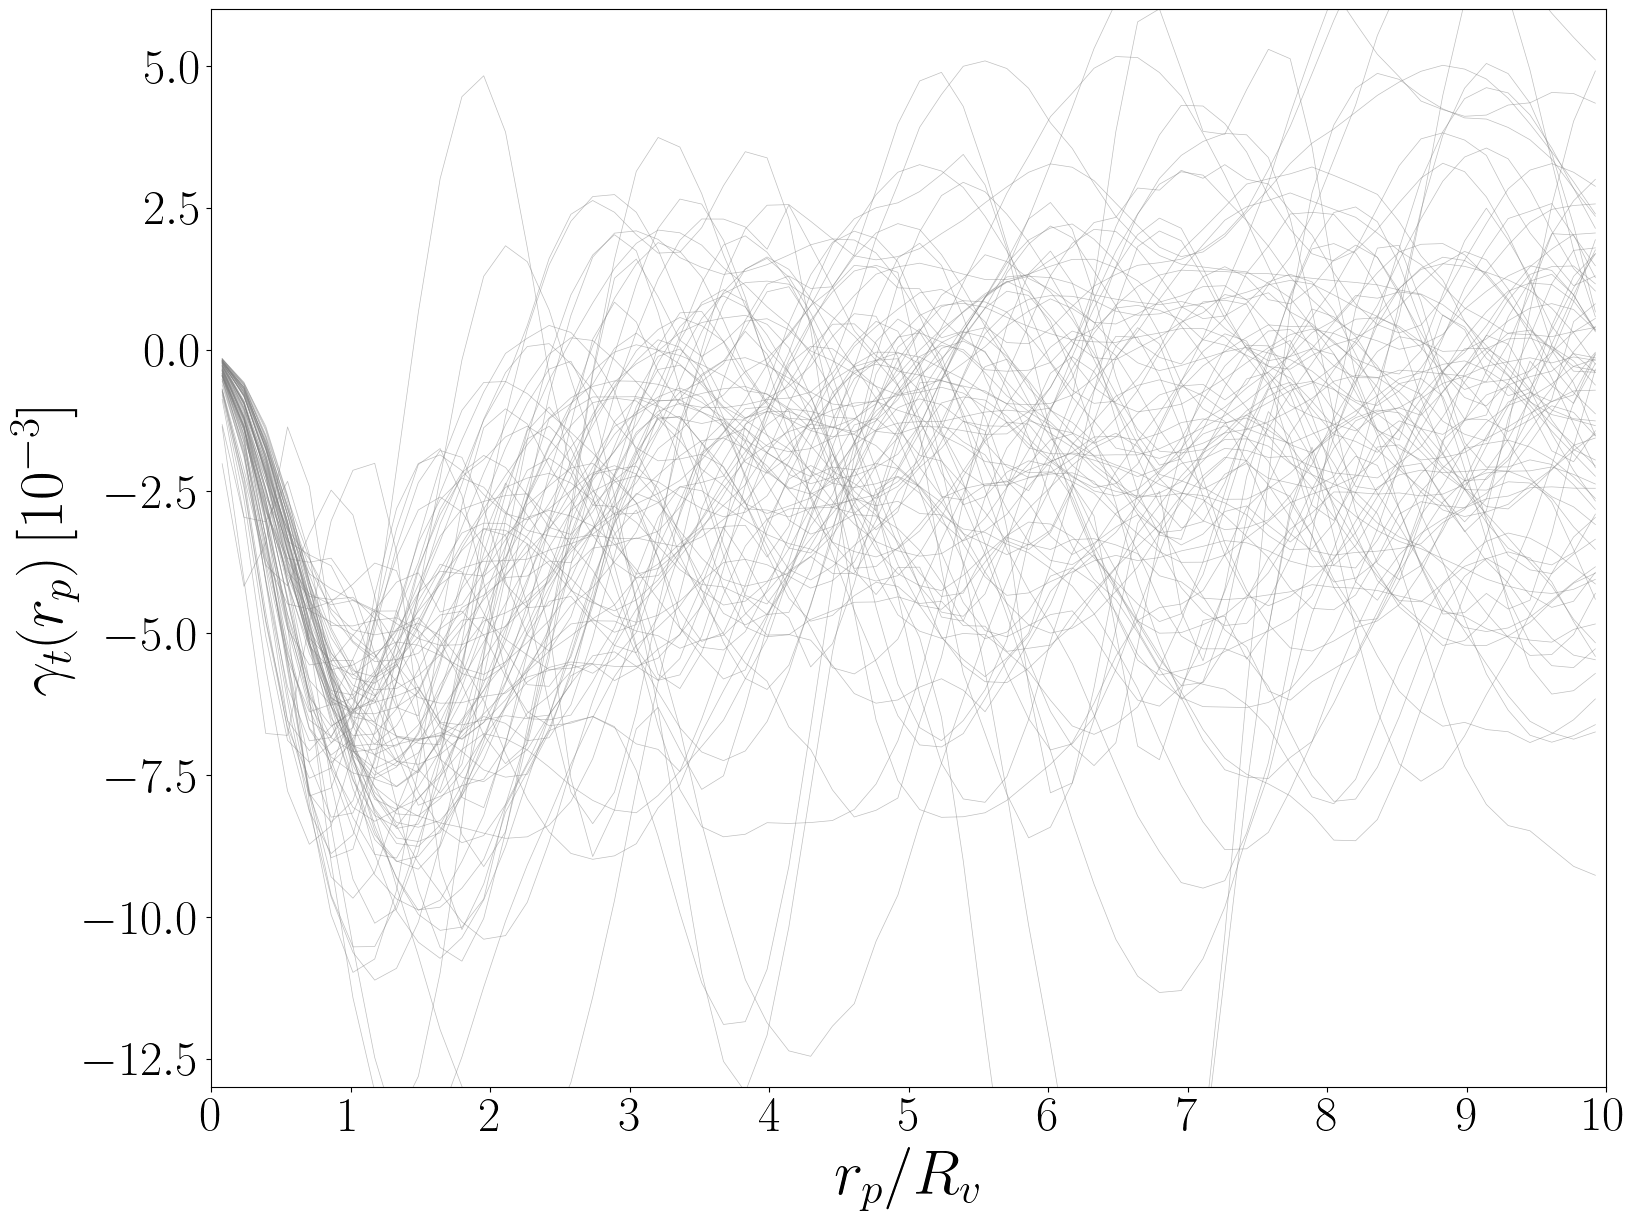

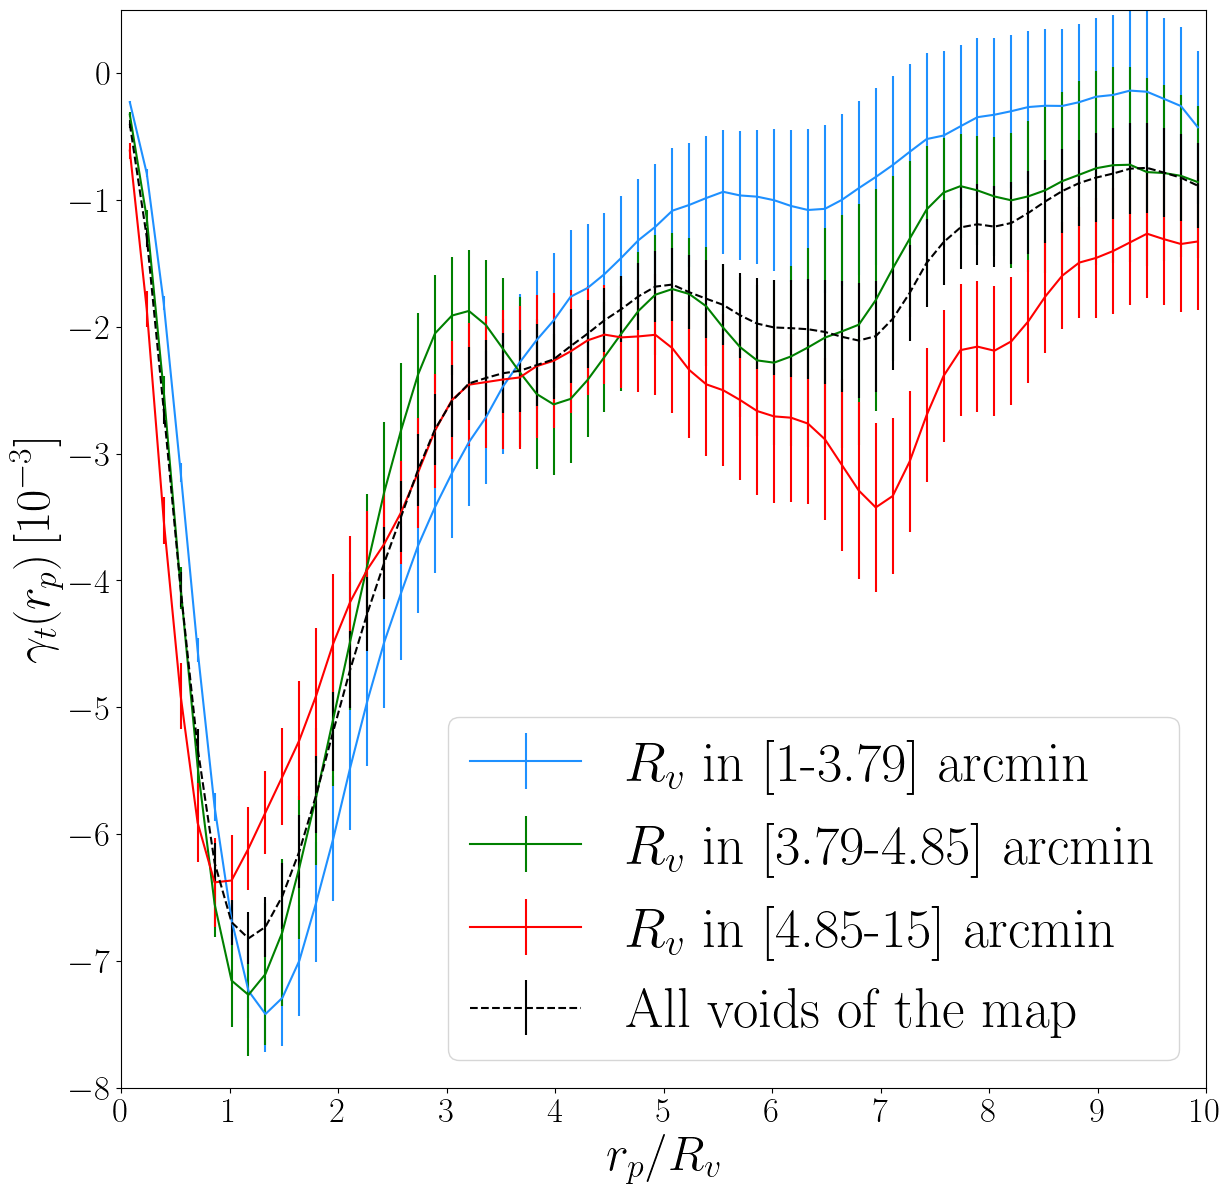

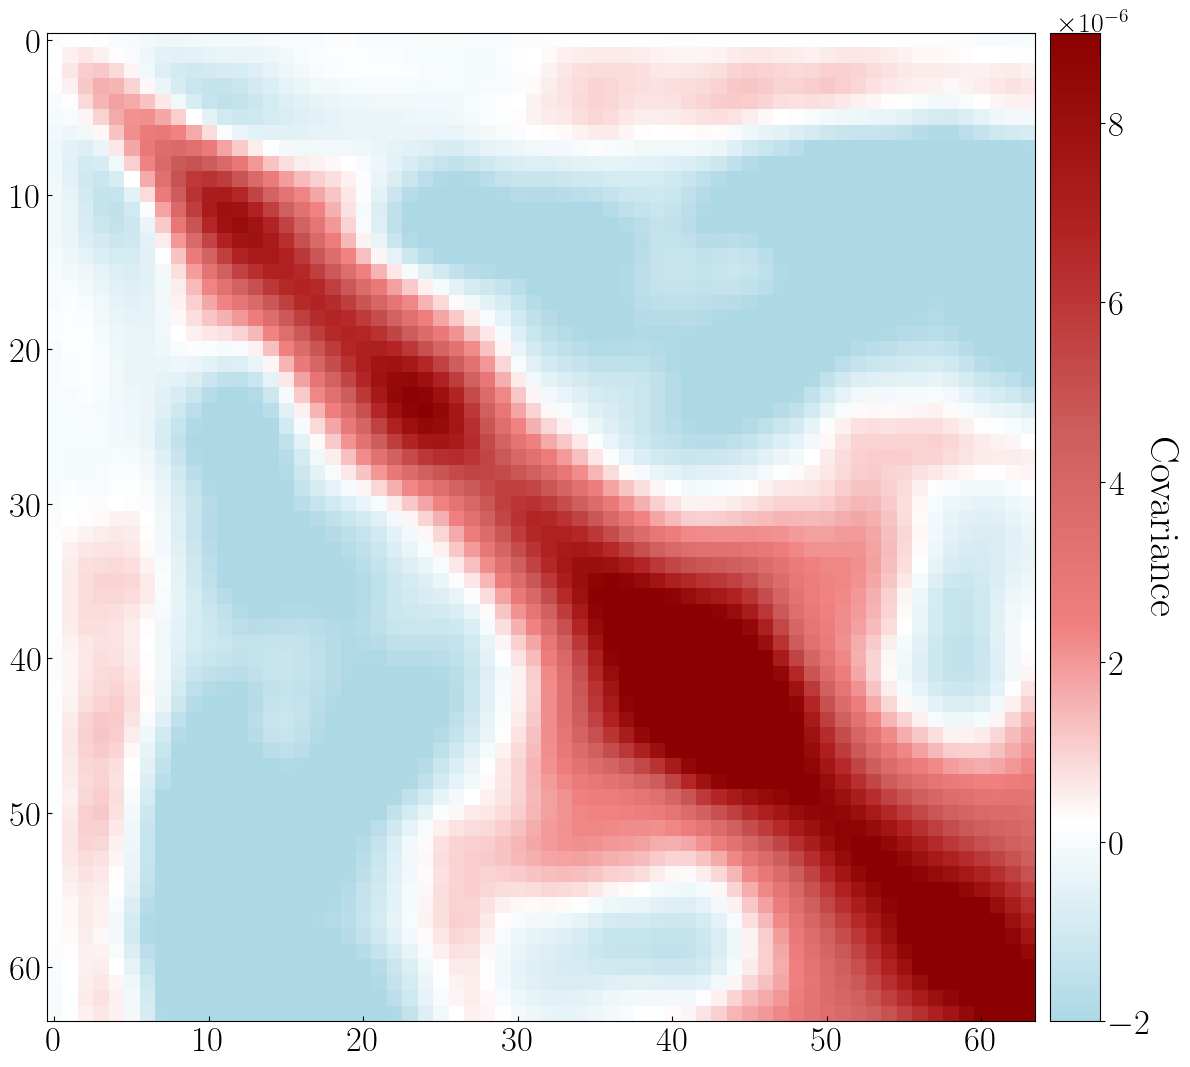

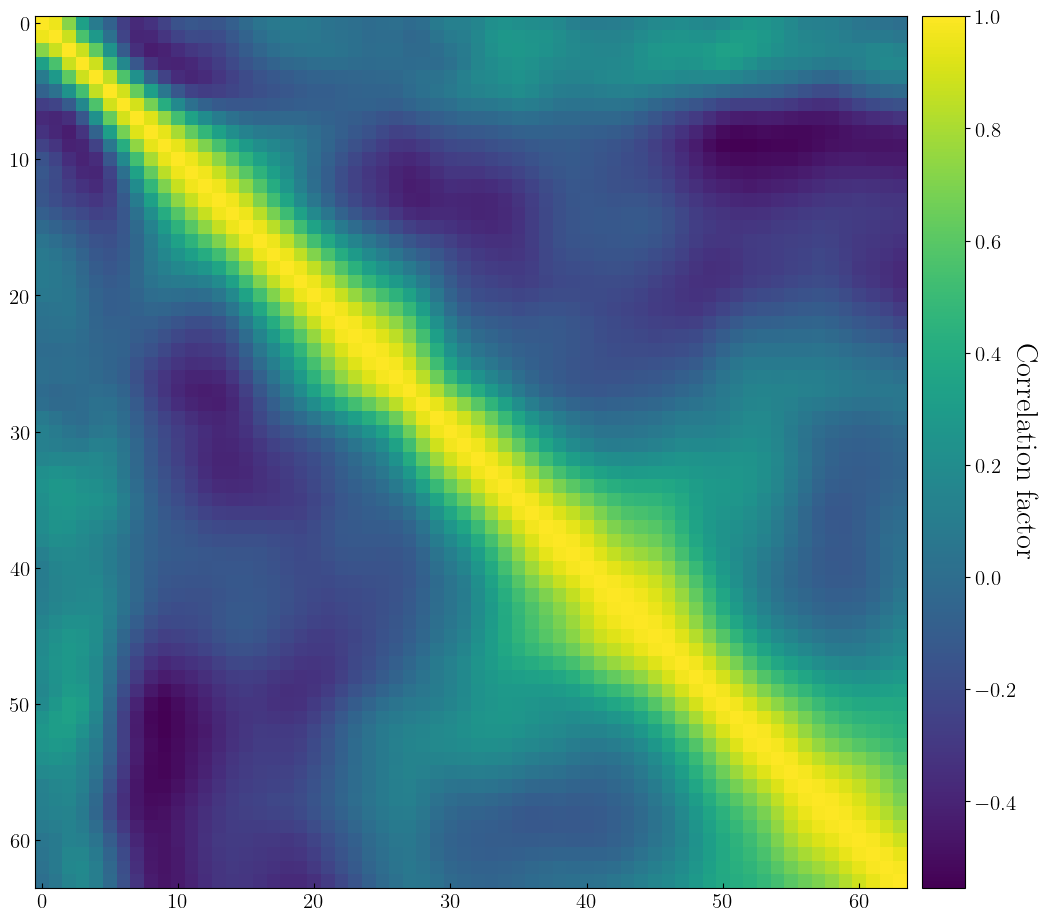

In [6]:
if exist:
    r_out, nbins, fradius = mystery.shells_profile(folderout,
                                                   i_fil,
                                                   smooth_filter_set,
                                                   folder_names,
                                                   kappa_final,
                                                   equibins,
                                                   fov_arcmin,
                                                   npixel,
                                                   n_gal_set,
                                                   ell_err,
                                                   64,
                                                   20,
                                                   True)
    
    mystery.process_shear_map(folderout, l_c, folder_names, color, r_out, nbins, fradius, True)
    
else:
    print("No voids found")